**Project:** Sentiment Analysis of [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

**Author:** [Giuseppe Muschetta](https://github.com/peppe212)

**Python version:** 3.8

### DATA PREPARATION AND CLEANING

In [1]:
# Sopprimiamo i warnings
import warnings
warnings.filterwarnings('ignore')

# Gestione dei Path
from pathlib import Path

# Importo i miei 2 script da cui dipende questo notebook
import clean_text_script
import count_and_wordclouds

# Importiamo le librerie necessarie:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# Impostazioni dello stile Seaborn in ambiente globale
sns.set(
    style='whitegrid',
    palette='pastel',
    context='notebook',
    font_scale=1.1,
    rc={'lines.linewidth': 2, 'grid.linestyle': '--'}
)

### Setting Paths

In [2]:
# Carico il Dataset originale di Amazon Reviews
INPUT_DATASET_PATH = Path("Dataset/reviews_data_preparation.csv")
df = pd.read_csv(INPUT_DATASET_PATH)

# Gestione salvataggio dei dataset di output
OUTPUT_DATASET_PATH = Path() / "Dataset"
OUTPUT_DATASET_PATH.mkdir(parents=True, exist_ok=True)

# Salvo il dataset di output su un file .csv
def save_my_dataset(dataframe, dataset_name:str, dataset_extension="csv"):
    path = OUTPUT_DATASET_PATH / f"{dataset_name}.{dataset_extension}"
    try:
        dataframe.to_csv(path, index=False)
        print(f"Dataset salvato correttamente in: {path}")
    except Exception as e:
        print(f"Si è verificato un errore durante il salvataggio del dataset: {e}")
        raise FileNotFoundError
#end_function

In [3]:
# Visualizziamo le prime 10 righe del dataframe appena caricato
df.head(10)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...
5,4,I got a wild hair for taffy and ordered this f...
6,5,This saltwater taffy had great flavors and was...
7,5,This taffy is so good. It is very soft and ch...
8,5,Right now I'm mostly just sprouting this so my...
9,5,This is a very healthy dog food. Good for thei...


In [4]:
# Mostra la vera quantità di RAM utilizzata
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   568454 non-null  int64 
 1   Text    568454 non-null  object
dtypes: int64(1), object(1)
memory usage: 271.7 MB


In [5]:
# L'obiettivo è filtrare le recensioni in sole due clssi: positive e negative, 
# dato che quelle neutrali non servono allo scopo, ergo tutte le recensioni
# che hanno un punteggio pari a 3 non saranno contemplate
df = df[df['Score'] != 3]

# Tutte le recensioni con punteggio pari a 4 o 5 saranno positive e assegnamo loro l'etichetta 1
# Quelle negative avranno score pari a 1 o 2 e con etichetta di sentiment assegnata pari a 0
# Creo la colonna 'sentiment' 
df['sentiment'] = 0
df.loc[df['Score'] > 3, 'sentiment'] = 1
df.loc[df['Score'] < 3, 'sentiment'] = 0

# a questo punto possiamo eliminare la colonna 'Score'
df = df.drop(columns=['Score'])
df.head()

,Text,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [6]:
# ADESSO DOBBIAMO CERCARE DI RENDERE IL DATAFRAME EQUO
df['sentiment'].value_counts()
# dobbiamo fare in modo che le recensioni positive eguaglino quelle negative
# in modo da trainare un classificatore binario che possa esprimere il suo massimo potenziale

sentiment
1    443777
0     82037
Name: count, dtype: int64

In [7]:
# Per mantenere una certa equità tra le due classi: Positiva e Negativa
# È necessario equilibrarle con una procedura di down_sampling della classe maggioritaria

# Calcolo il numero di elementi per la classe minoritaria
minor_class_count = df['sentiment'].value_counts().min()

def downsampling_k_elements(group, k=minor_class_count):
    return group.sample(n=k, random_state=42)

# Applico la funzione di downsampling alla classe maggioritaria usando la funzione di ordine superiore apply
df_balanced = df.groupby('sentiment').apply(downsampling_k_elements)

# Mescolo le righe del DataFrame risultante per evitare che le classi siano consecutive in blocco, cioè
# le prime 82k di classe 0 e altre 82k di classe 1
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verifico i conteggi per confermare che il downsampling è stato eseguito correttamente
print(df_balanced['sentiment'].value_counts())


sentiment
0    82037
1    82037
Name: count, dtype: int64


In [8]:
df_balanced.head()

,Text,sentiment
0,ok. not too many ingredients from barbecue sau...,0
1,This granola has all the right ingredients - n...,0
2,I have this coffee in the past and really enjo...,0
3,I have tried the Sans Sucre Vanilla mousse and...,0
4,"I usually dont like black herbal tea, but this...",1


In [9]:
# facciamo una deep copy del dataset in modo che le modifiche al precedente non
# si riflettano sull'attuale come avverrebbe se la copia fosse stata fatta in 
# modalità shallow: deep=False
df = df_balanced.copy(deep=True)
df.head()

,Text,sentiment
0,ok. not too many ingredients from barbecue sau...,0
1,This granola has all the right ingredients - n...,0
2,I have this coffee in the past and really enjo...,0
3,I have tried the Sans Sucre Vanilla mousse and...,0
4,"I usually dont like black herbal tea, but this...",1


#### Saving the raw but balanced dataset for DistilBERT model

In [10]:
# SALVIAMO QUESTO DATAFRAME CONTENENTE TESTO GREZZO MA BILANCIATO 
# PERCHÉ LO USERÀ IL BERT e/o il DistilBERT
save_my_dataset(df, "balanced_reviews")

Dataset salvato correttamente in: Dataset/balanced_reviews.csv


## TEXT PROCESSING AND DATA CLEANING

### Libraries used:

**NLTK** library is used to load English stopwords.

With **BeautifulSoup** we can remove very efficiently HTML tags.

With Regular Expressions **RE** we removed all email and URLs from the text.

**spaCy** powerful integrated pipeline of text processing components.

**Emoji**, if present, are preserved because they add positive and/or negative sentiment**.

**Contractions** will expand things like: here's you're should've etc.

**Gensim** to detect Collocations (Bigrams)

**My own functions** to handle negations in text.

**OBSERVATION: lemmatization is implicitly done by the powerful spaCy text processing pipeline.**

In [11]:
%%time
# IL CUORE DELLA FASE DI CLEANING È CONTENUTA NEL MIO SCRIPT: clean_text_script
# applica la funzione di pulizia presente nel file clean_text_script.py
# l'esecuzione della seguente riga di codice impiegherà parecchio tempo
# sulla mia macchina impiega circa 15 minuti
df['cleaned_text'] = df['Text'].apply(clean_text_script.clean_text)

CPU times: user 14min 55s, sys: 11.8 s, total: 15min 7s
Wall time: 15min 11s


In [12]:
df

,Text,sentiment,cleaned_text
0,ok. not too many ingredients from barbecue sau...,0,not_too many barbecue sauce actually hardly ta...
1,This granola has all the right ingredients - n...,0,granola right somehow find bland bore sad
2,I have this coffee in the past and really enjo...,0,past really enjoy however receive weak sisteri...
3,I have tried the Sans Sucre Vanilla mousse and...,0,try sucre like even feel faint bitter aftertas...
4,"I usually dont like black herbal tea, but this...",1,usually not_like herbal able sip face full aro...
...,...,...,...
164069,"I have to say, I'm definitely looking for a de...",1,say definitely look deal baby price even coupo...
164070,I remember when Izze was first introduced a fe...,1,remember izze first introduce back immediately...
164071,So far I have really enjoyed this kit. The col...,1,far really enjoy kit bright vibrant reason mar...
164072,"Everything i expected from Amamzon.com, - ver...",1,expect good lover careful not_to strong


### WORDCLOUD SUL TESTO GREZZO

In [13]:
# imposto il numero massimo di parole da considerare nello studio delle parole più frequenti
max_words = 300

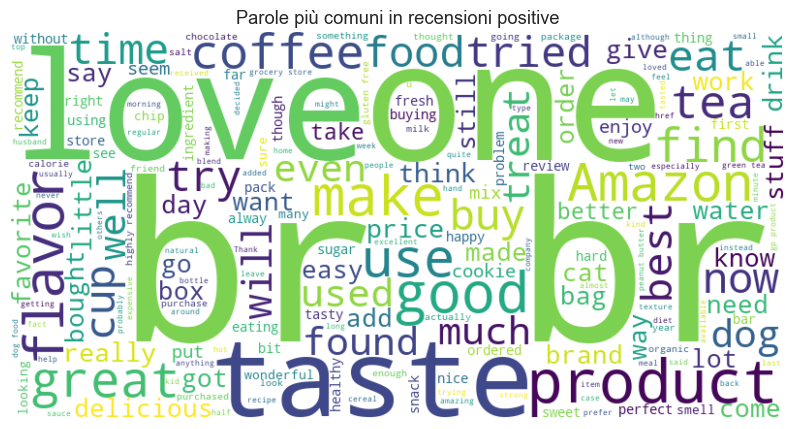

In [14]:
# wordcloud del testo grezzo con sentimento positivo
count_and_wordclouds.generate_wordcloud(df, 'Text', 1, 'white', 'positive_raw_text')

In [15]:
# stampo le max_words parole con sentiment positivo piu' frequenti nel testo raw
most_common_raw_positive_words = count_and_wordclouds.count_most_common_words(df, 'Text', 1, max_words)

Le 300 parole più frequenti nelle recensioni positive sono:
.: 331627
,: 237252
I: 223429
the: 218562
and: 179712
a: 168112
to: 138256
it: 116576
of: 107432
is: 106532
>: 91986
<: 91664
/: 87251
br: 86929
for: 76070
in: 73603
this: 69490
!: 68014
that: 57678
my: 52682
have: 49808
with: 48888
you: 47845
are: 47448
but: 43082
's: 41394
was: 38494
n't: 37658
on: 36983
not: 36733
as: 36001
like: 32915
): 30972
so: 30646
them: 30415
they: 30388
The: 29537
(: 28329
It: 28155
good: 26755
these: 25699
or: 24936
at: 23839
be: 23818
great: 22919
This: 22241
one: 21498
coffee: 21429
do: 21193
taste: 21109
just: 21029
very: 20878
can: 20693
all: 19412
flavor: 19326
has: 18672
from: 18636
'': 18603
more: 18447
product: 18292
tea: 18038
love: 17436
me: 17422
food: 16523
will: 16266
than: 16247
when: 15738
had: 15620
would: 15583
out: 15092
get: 14902
if: 14380
other: 14306
My: 14242
about: 14021
``: 13824
up: 13669
some: 13571
really: 13244
only: 13205
They: 12911
've: 12841
too: 12770
we: 12359
use

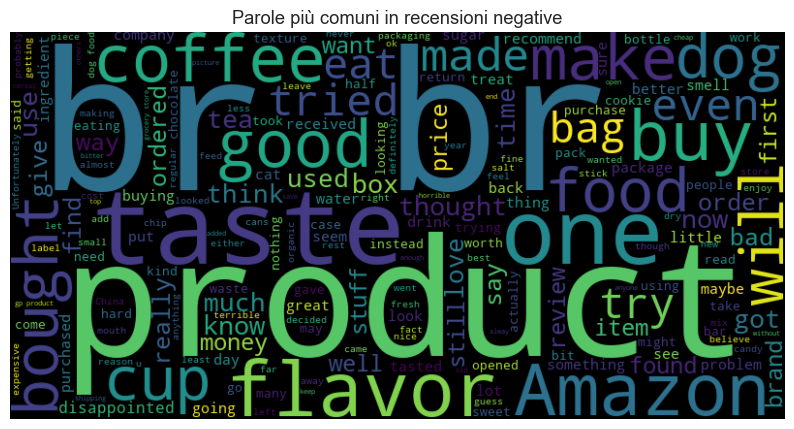

In [16]:
# wordcloud del testo grezzo con sentimento negativo
count_and_wordclouds.generate_wordcloud(df, 'Text', 0, 'black', 'negative_row_text')

In [17]:
# stampo le max_words parole con sentiment negativo piu' frequenti nel testo raw
most_common_raw_negative_words = count_and_wordclouds.count_most_common_words(df, 'Text', 0, max_words)

Le 300 parole più frequenti nelle recensioni positive sono:
.: 388988
the: 285710
I: 276265
,: 275177
and: 175767
a: 161177
to: 158922
it: 136755
of: 132130
>: 108776
<: 108450
/: 104965
br: 104604
is: 101251
this: 92586
was: 79036
in: 78743
that: 75317
for: 70793
not: 69244
n't: 57980
but: 57946
my: 51310
have: 50264
!: 49591
with: 47739
you: 43549
like: 42805
's: 41746
on: 40373
are: 39897
they: 39244
The: 37150
as: 36501
be: 34955
product: 31167
taste: 30330
): 30235
(: 30183
so: 30177
would: 29089
It: 28301
had: 28187
'': 27700
from: 27625
them: 27214
at: 26883
do: 26327
just: 25865
these: 25504
one: 25017
or: 24608
all: 24110
``: 23754
very: 21292
food: 21176
were: 21050
me: 20940
out: 20781
coffee: 20473
good: 20278
This: 20032
can: 19489
flavor: 19344
did: 19199
will: 18905
more: 18398
if: 18324
has: 18133
no: 16955
...: 16619
when: 16025
about: 15813
other: 15783
get: 15634
because: 15556
up: 15494
what: 15345
?: 15338
even: 14458
tea: 14277
an: 14274
only: 14209
buy: 13949
tha

### WORDCLOUD SUL TESTO PROCESSATO E PULITO

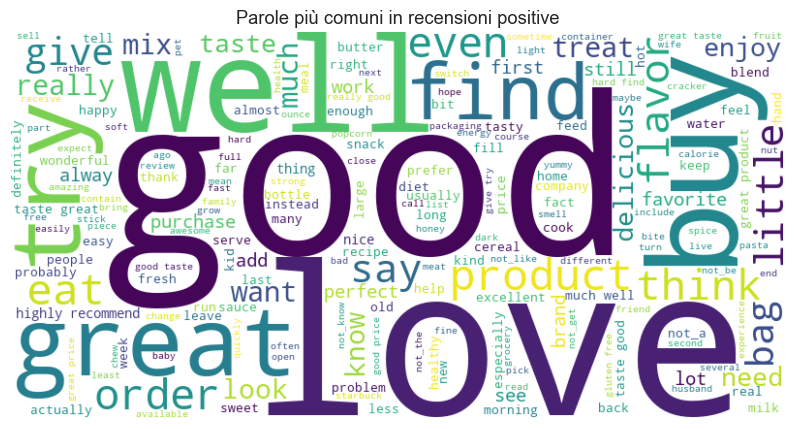

In [18]:
# wordcloud del testo pulito con sentimento positivo
count_and_wordclouds.generate_wordcloud(df, 'cleaned_text', 1, 'white', 'positive_cleaned_text')

In [19]:
# stampo le max_words parole con sentiment positivo piu' frequenti nel testo cleaned
most_common_cleaned_positive_words = count_and_wordclouds.count_most_common_words(df, 'cleaned_text', 1, max_words)

Le 300 parole più frequenti nelle recensioni positive sono:
good: 39260
taste: 30479
love: 29221
great: 26968
flavor: 26778
product: 22169
get: 22011
try: 21606
buy: 19391
well: 18924
find: 17971
like: 15256
eat: 15115
really: 12619
also: 12203
price: 12183
much: 11899
order: 11782
little: 11781
bag: 11378
give: 10501
treat: 9734
add: 9407
recommend: 8730
think: 8710
say: 8394
even: 8272
first: 7846
brand: 7695
mix: 7397
favorite: 7347
look: 7342
water: 7335
sweet: 7168
work: 7067
keep: 6827
snack: 6798
want: 6784
purchase: 6668
enjoy: 6612
thing: 6514
bit: 6452
healthy: 6438
nice: 6407
lot: 6255
delicious: 6176
easy: 5951
need: 5929
many: 5818
still: 5709
know: 5583
perfect: 5534
see: 5528
always: 5489
long: 5382
hot: 5097
right: 5074
free: 5072
strong: 5019
old: 4657
milk: 4597
less: 4574
enough: 4495
fresh: 4471
different: 4454
happy: 4392
definitely: 4337
far: 4278
hard: 4177
feel: 4160
review: 4124
calorie: 4072
tasty: 4028
wonderful: 3973
back: 3941
last: 3894
help: 3861
excellen

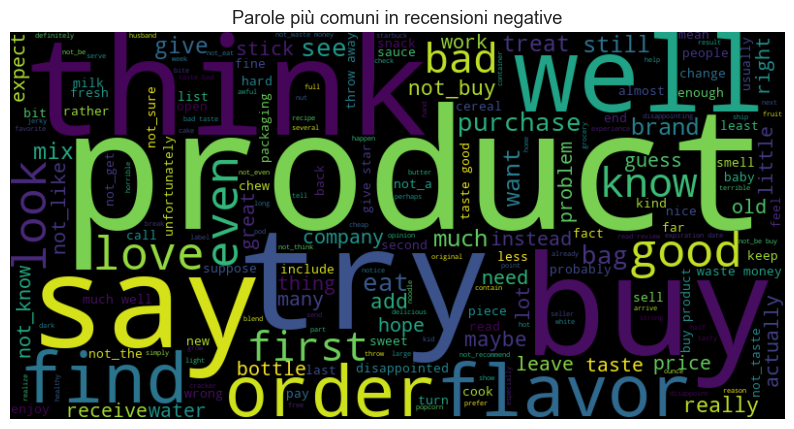

In [20]:
# wordcloud del testo pulito con sentiment negativo
count_and_wordclouds.generate_wordcloud(df, 'cleaned_text', 0, 'black', 'negative_cleaned_text')

In [21]:
# stampo le max_words parole con sentiment negativo piu' frequenti nel testo cleaned
most_common_cleaned_negative_words = count_and_wordclouds.count_most_common_words(df, 'cleaned_text', 0, max_words)

Le 300 parole più frequenti nelle recensioni positive sono:
taste: 42293
product: 37509
flavor: 25482
get: 25464
try: 24789
buy: 24697
good: 23178
eat: 16480
think: 16303
order: 16071
well: 15228
bag: 14463
bad: 13672
give: 13471
find: 13065
say: 13064
much: 12907
love: 12446
really: 12412
look: 12055
first: 11341
even: 11285
like: 11198
purchase: 10148
review: 9707
also: 9679
water: 9214
little: 8944
price: 8914
want: 8705
brand: 8679
great: 8241
thing: 8062
smell: 7928
see: 7847
know: 7739
still: 7340
back: 7304
money: 7153
treat: 7090
receive: 6937
open: 6926
old: 6622
company: 6046
add: 6003
however: 5955
different: 5719
away: 5624
sweet: 5570
many: 5565
throw: 5542
mix: 5521
lot: 5196
leave: 5158
read: 5123
people: 5113
disappointed: 5016
hard: 4981
new: 4890
bottle: 4865
not_be: 4841
less: 4832
maybe: 4810
not_buy: 4775
not_even: 4769
problem: 4719
almost: 4666
feel: 4655
need: 4589
work: 4563
not_like: 4536
kind: 4524
stick: 4418
star: 4395
last: 4344
hope: 4308
bit: 4275
actual

### STUDIO DELLA SIMILARITÀ (INTESA COME DISTANZA)

In [22]:
# STAMPIAMO LE FREQUENZE DELLE PAROLE IN COMUNE NEI DUE SENTIMENTI:
# una volta trovate le parole in comune, le stamperemo in questo modo: 
# (parola_in_comune, freq_sentiment_positivo, freq_sentiment_negativo)

# Converto le liste di tuple in dizionari
positive_word_freq = dict(most_common_cleaned_positive_words)
negative_word_freq = dict(most_common_cleaned_negative_words)

# Trovo le parole in comune come intersezione
common_words = set(positive_word_freq.keys()) & set(negative_word_freq.keys())

# Tifo fuori le prime n parole comuni ordinate per la somma delle frequenze
common_words_data = [(word, positive_word_freq[word], negative_word_freq[word])
                     for word in common_words]
# Ordino per frequenza totale decrescente
common_words_data.sort(key=lambda x: -(x[1] + x[2]))

# Stampo le parole comuni con le frequenze per sentiment positivo e negativo
print("Parole comuni con frequenze per sentiment positivo e negativo:")
for word, pos_freq, neg_freq in common_words_data:
    print(f"{word}: Frequenza Positiva = {pos_freq}, Frequenza Negativa = {neg_freq}")


Parole comuni con frequenze per sentiment positivo e negativo:
taste: Frequenza Positiva = 30479, Frequenza Negativa = 42293
good: Frequenza Positiva = 39260, Frequenza Negativa = 23178
product: Frequenza Positiva = 22169, Frequenza Negativa = 37509
flavor: Frequenza Positiva = 26778, Frequenza Negativa = 25482
get: Frequenza Positiva = 22011, Frequenza Negativa = 25464
try: Frequenza Positiva = 21606, Frequenza Negativa = 24789
buy: Frequenza Positiva = 19391, Frequenza Negativa = 24697
love: Frequenza Positiva = 29221, Frequenza Negativa = 12446
great: Frequenza Positiva = 26968, Frequenza Negativa = 8241
well: Frequenza Positiva = 18924, Frequenza Negativa = 15228
eat: Frequenza Positiva = 15115, Frequenza Negativa = 16480
find: Frequenza Positiva = 17971, Frequenza Negativa = 13065
order: Frequenza Positiva = 11782, Frequenza Negativa = 16071
like: Frequenza Positiva = 15256, Frequenza Negativa = 11198
bag: Frequenza Positiva = 11378, Frequenza Negativa = 14463
really: Frequenza Po

In [30]:
# STUDIO DELLA DISTANZA: parole potenzialmente irrilevanti
# questo algoritmo ci restituisce una lista di parole da considerare potenzialmente irrilevanti
# Grazie alla lista di parole in comune possiamo ancora di piu' migliorare la stop-word list
# andremo ad aggiungere tali parole irrilevanti alle stopwords in modo che vengano ignorate dalla
# nostra sentiment analysis

threshold = 0.05 # calcolato come percentuale
words_to_add_to_stopwords = []
for word, freqP, freqN in common_words_data:
    delta = abs(freqP - freqN)
    irrelevant_factor = (delta/len(df)) * 100
    if irrelevant_factor <= threshold:
        words_to_add_to_stopwords.append(word)
    
if not words_to_add_to_stopwords:    
    print("lista vuota! si provi ad aumentare il threshold di un centesimo alla volta...\n"
          "oppure è già stata fatta una buona scrematura e non serve procedere ulteriormente\n")
else:
    print("Parole irrilevanti da aggiungere potenzialmente alle stopwords:\n", words_to_add_to_stopwords)
# quando sarà terminato il progetto, questa lista avrà già dato buona parte della sua utilità
# dato che tutte le parole filtrate saranno già state aggiunte alle stop words

lista vuota! si provi ad aumentare il threshold di un centesimo alla volta...
oppure è già stata fatta una buona scrematura e non serve procedere ulteriormente



In [24]:
# LE ATTUALI STOP-WORDS CONTENGONO LE SEGUENTI PAROLE:
# sono le stopwords predefinite di nltk piu' quelle aggiunte dopo varie scremature
list_of_stop_words = list(clean_text_script.stop_words)
list_of_stop_words.sort()
print(list_of_stop_words)

['a', 'about', 'above', 'accessory', 'account', 'after', 'again', 'against', 'ain', 'all', 'am', 'amazon', 'an', 'and', 'any', 'application', 'are', 'aren', "aren't", 'around', 'article', 'as', 'aspect', 'at', 'bar', 'basis', 'batch', 'be', 'bean', 'because', 'become', 'beef', 'been', 'before', 'being', 'below', 'between', 'big', 'black', 'both', 'bowl', 'box', 'brew', 'budget', 'but', 'button', 'by', 'can', 'candy', 'capacity', 'cart', 'case', 'cat', 'category', 'checkout', 'cheese', 'chicken', 'chip', 'chocolate', 'click', 'coconut', 'coffee', 'color', 'come', 'compare', 'component', 'consumer', 'content', 'cookie', 'cost', 'couldn', "couldn't", 'couple', 'coverage', 'cup', 'd', 'day', 'delivery', 'design', 'did', 'didn', "didn't", 'dimension', 'discount', 'do', 'does', 'doesn', "doesn't", 'dog', 'doing', 'don', "don't", 'down', 'drink', 'dry', 'duration', 'during', 'each', 'entity', 'ever', 'expensive', 'fan', 'feature', 'few', 'food', 'for', 'format', 'from', 'further', 'go', 'grad

In [25]:
# CALCOLO DEL VOCABOLARIO COMPLETO, cioè quanti token unici abbiamo
# Inizializzo un insieme per tracciare i token unici
unique_words = set()

for text in df['cleaned_text']:
    words = text.split() 
    unique_words.update(words)

# Calcolo il numero di token unici
total_unique_words = len(unique_words)
print(f"Numero di token unici nel dataset: {total_unique_words}")
# anche in questo caso vale la proporzione paretica: 80% occorrono quasi con freqjuenza zero e quindi li scarto
# il 20% li mantengo e ciò sarà utilizzato come vocab_size nel modello di deep learning

Numero di token unici nel dataset: 139099


In [26]:
df.head()

,Text,sentiment,cleaned_text
0,ok. not too many ingredients from barbecue sau...,0,not_too many barbecue sauce actually hardly ta...
1,This granola has all the right ingredients - n...,0,granola right somehow find bland bore sad
2,I have this coffee in the past and really enjo...,0,past really enjoy however receive weak sisteri...
3,I have tried the Sans Sucre Vanilla mousse and...,0,try sucre like even feel faint bitter aftertas...
4,"I usually dont like black herbal tea, but this...",1,usually not_like herbal able sip face full aro...


In [27]:
# Prepariamo il salvataggio del dataset ripulito che sarà utilizzato
# come input dai modelli Naïve Bayes, LinearSVC e Deep Learning
df = df.drop(columns=['Text'])

In [28]:
df.head(10)

,sentiment,cleaned_text
0,0,not_too many barbecue sauce actually hardly ta...
1,0,granola right somehow find bland bore sad
2,0,past really enjoy however receive weak sisteri...
3,0,try sucre like even feel faint bitter aftertas...
4,1,usually not_like herbal able sip face full aro...
5,1,love raw cacao great taste raw fruitveggie smo...
6,0,delicious seller send melt melt guess expire n...
7,0,taste little microwave popcorn not_all bacon s...
8,1,product die heal skin inside concern recommend...
9,0,first buy try eat not_looked find mostly pig h...


In [29]:
# Salvo il dataframe cleaned per Naïve Bayes, LinearSVC e Deep Learning models
save_my_dataset(df, "cleaned_reviews")

Dataset salvato correttamente in: Dataset/cleaned_reviews.csv
